In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageEnhance
import os
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

def clear_gpu_memory():
    torch.cuda.empty_cache()
    print("GPU memory cleared")

clear_gpu_memory()

Using device: cuda
GPU Name: NVIDIA GeForce GTX 1660 Ti
GPU memory cleared


In [51]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

try:
    content_image = Image.open('content_img4.jpg').convert('RGB')
    style_image = Image.open('style_img4.png').convert('RGB')
except FileNotFoundError as e:
    raise FileNotFoundError(f"Image not found: {e}. Upload images to /kaggle/input/")

content_tensor = transform(content_image).unsqueeze(0).to(device)
style_tensor = transform(style_image).unsqueeze(0).to(device)

print(f"Content Tensor Shape: {content_tensor.shape}")
print(f"Style Tensor Shape: {style_tensor.shape}")

Content Tensor Shape: torch.Size([1, 3, 256, 256])
Style Tensor Shape: torch.Size([1, 3, 256, 256])


In [52]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()
content_layers = ['conv_4_2']
style_layers = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']
layer_names = {
    '0': 'conv_1_1', '5': 'conv_2_1', '10': 'conv_3_1', 
    '19': 'conv_4_1', '21': 'conv_4_2', '28': 'conv_5_1'
}

class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        self.vgg = vgg
        self.content_layers = content_layers
        self.style_layers = style_layers
    
    def forward(self, x):
        content_features = []
        style_features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            name = layer_names.get(str(i))
            if name in self.content_layers:
                content_features.append(x)
            if name in self.style_layers:
                style_features.append(x)
        return content_features, style_features

feature_extractor = VGGFeatureExtractor().to(device)

/home/akshatubuntu/miniconda3/envs/env1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akshatubuntu/miniconda3/envs/env1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
def content_loss(target, content):
    return nn.MSELoss()(target, content)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(b * c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram.div(b * c * h * w)

def style_loss(target, style):
    loss = 0
    for t, s in zip(target, style):
        t_gram = gram_matrix(t)
        s_gram = gram_matrix(s)
        layer_loss = nn.MSELoss()(t_gram, s_gram)
        loss += layer_loss
    return loss

def total_variation_loss(image):
    return torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
           torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))

In [54]:
class StyleTransferModel(nn.Module):
    def __init__(self):
        super(StyleTransferModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )
        for module in self.model:
            if isinstance(module, nn.Conv2d):
                nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.zeros_(module.bias)

    def forward(self, x):
        return torch.tanh(self.model(x))

# Initialize model
model = StyleTransferModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)  # Reduced from 0.005
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # Reintroduced

In [55]:
# Hyperparameters
num_epochs = 300
content_weight = 5.0
style_weight = 1e6
tv_weight = 5e-3

# Lists to save losses
content_losses = []
style_losses = []
tv_losses = []
total_losses = []

# Precompute style and content features
model.eval()
with torch.no_grad():
    _, style_feats = feature_extractor(style_tensor)
    content_feats, _ = feature_extractor(content_tensor)

# Training with Adam
model.train()
import time

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Three forward/backward passes per epoch
    for _ in range(12):  # Changed from 2 to 3
        stylized_image = model(content_tensor)
        stylized_content_feats, stylized_style_feats = feature_extractor(stylized_image)
        
        # Compute losses
        c_loss = content_loss(stylized_content_feats[0], content_feats[0])
        s_loss = style_loss(stylized_style_feats, style_feats)
        tv_loss = total_variation_loss(stylized_image)
        
        # Total loss
        weighted_s_loss = style_weight * s_loss
        loss = content_weight * c_loss + weighted_s_loss + tv_weight * tv_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    scheduler.step()
    
    # Save losses (after last pass)
    content_losses.append(c_loss.item())
    style_losses.append(s_loss.item())
    tv_losses.append(tv_loss.item())
    total_losses.append(loss.item())
    
    # Calculate time taken and it/s
    end_time = time.time()
    epoch_time = end_time - start_time
    it_s = 1 / epoch_time  # Still 1 "iteration" per epoch for logging
    
    # Print progress every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Content Loss: {c_loss.item():.4f} | Style Loss: {weighted_s_loss.item():.6f} | "
          f"TV Loss: {tv_loss.item():.4f} | Total Loss: {loss.item():.4f} | "
          f"Time: {epoch_time:.2f}s | It/s: {it_s:.2f}")

# Save the model
torch.save(model.state_dict(), 'new_model.pth')

# Save the final stylized image with color enhancement
with torch.no_grad():
    final_stylized = model(content_tensor)
    final_stylized = final_stylized.squeeze(0).cpu()
    final_stylized = (final_stylized + 1) / 2
    final_stylized = final_stylized * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    final_stylized = final_stylized.clamp(0, 1)
    output_image = transforms.ToPILImage()(final_stylized)
    output_image = ImageEnhance.Color(output_image).enhance(1.5)
    output_image.save('stylized_output5.jpg')

clear_gpu_memory()

Epoch [1/300] | Content Loss: 21.6706 | Style Loss: 656.854004 | TV Loss: 30241.7812 | Total Loss: 916.4161 | Time: 2.82s | It/s: 0.36
Epoch [2/300] | Content Loss: 22.3001 | Style Loss: 527.282654 | TV Loss: 30855.4570 | Total Loss: 793.0604 | Time: 2.81s | It/s: 0.36
Epoch [3/300] | Content Loss: 22.8844 | Style Loss: 452.715271 | TV Loss: 30584.2734 | Total Loss: 720.0588 | Time: 2.82s | It/s: 0.36
Epoch [4/300] | Content Loss: 23.2704 | Style Loss: 403.709259 | TV Loss: 31241.7891 | Total Loss: 676.2700 | Time: 2.82s | It/s: 0.35
Epoch [5/300] | Content Loss: 23.2755 | Style Loss: 372.451599 | TV Loss: 31350.7520 | Total Loss: 645.5828 | Time: 2.83s | It/s: 0.35
Epoch [6/300] | Content Loss: 23.5061 | Style Loss: 346.812622 | TV Loss: 32062.8828 | Total Loss: 624.6577 | Time: 2.83s | It/s: 0.35
Epoch [7/300] | Content Loss: 23.5948 | Style Loss: 322.778839 | TV Loss: 32318.6484 | Total Loss: 602.3461 | Time: 2.83s | It/s: 0.35
Epoch [8/300] | Content Loss: 23.5952 | Style Loss: 309

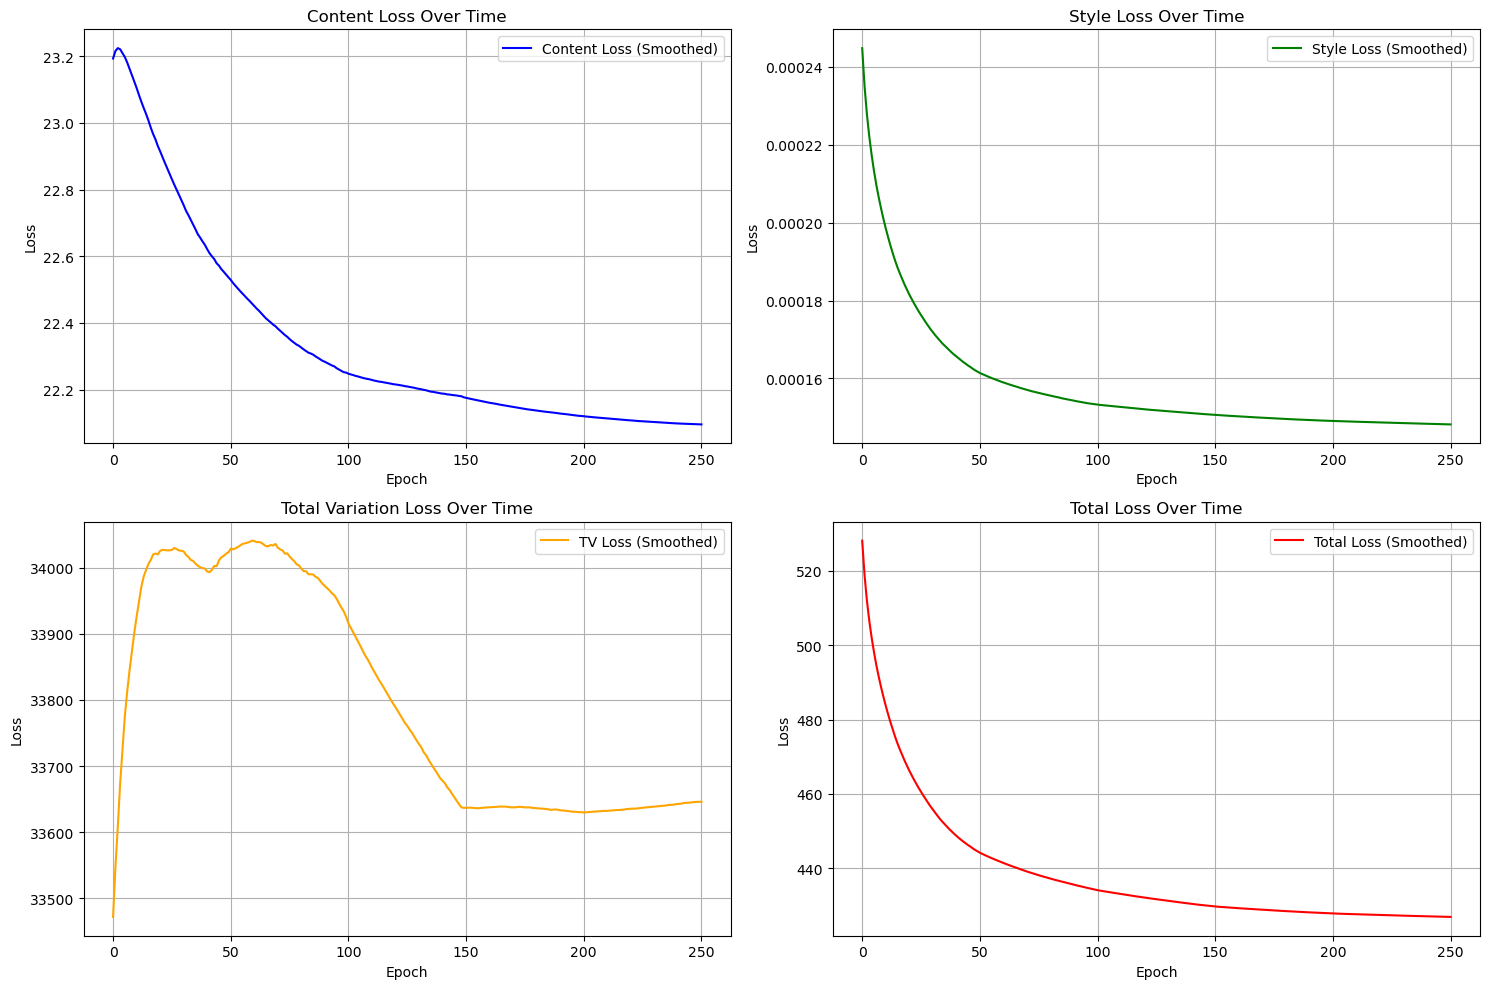

In [58]:
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(moving_average(content_losses, window_size), label='Content Loss (Smoothed)', color='blue')
plt.title('Content Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(moving_average(style_losses, window_size), label='Style Loss (Smoothed)', color='green')
plt.title('Style Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(moving_average(tv_losses, window_size), label='TV Loss (Smoothed)', color='orange')
plt.title('Total Variation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(moving_average(total_losses, window_size), label='Total Loss (Smoothed)', color='red')
plt.title('Total Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

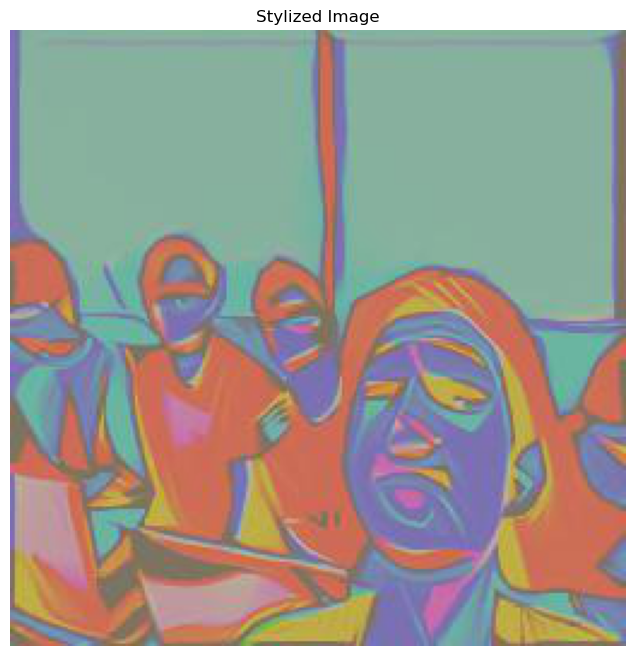

In [59]:
# Cell 8: Display the stylized image in the notebook
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image

# Load the saved stylized image
stylized_image_path = 'stylized_output5.jpg'
stylized_image = Image.open(stylized_image_path)

# Display the image
plt.figure(figsize=(8, 8))
imshow(stylized_image)
plt.axis('off')
plt.title('Stylized Image')
plt.show()